# Import

In [2]:
from utils.plot_config import *
import pandas as pd
import numpy as np
import os

import matplotlib.colors as mcolors
from matplotlib.ticker import FixedLocator, NullFormatter
from sklearn.preprocessing import MinMaxScaler

# Data

In [14]:
models = [
    'DLinear', 'PatchTST', 'TimesNet', 'iTransformer', 
    'TimeMixer', 'CALF',  'TimeLLM', 'OFA'
]
datasets = [
    'SPX500', 'Apple', 'MSFT', 
    'Crude_Oil', 'Gold', 'Natural_Gas', 
    'Exchange_Rate_Report', 'Financial_Aid_State'
]

datasets_map = {
    'SPX500': 'S&P 500',
    'Apple': 'Apple',
    'MSFT': 'Microsoft',
    'Crude_Oil': 'Crude Oil',
    'Gold': 'Gold',
    'Natural_Gas': 'Natural Gas',
    'Exchange_Rate_Report': 'Exchange Rate',
    'Financial_Aid_State': 'Financial Aid'
}

# Plot

## Test

In [ ]:
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)

In [ ]:
nrows = 2
ncols = 4
assert nrows * ncols >= len(datasets)
fig, axes = plt.subplots(nrows, ncols, figsize=(43, 12))

for i in range(nrows):
    for j in range(ncols):
        ax = axes[i][j]
        if i * ncols + j >= len(datasets): continue
        
        dataset = datasets[i * ncols + j]
        # print(dataset)
        
        if dataset == 'Financial_Aid_State':
            sl, pl = 10, 1
            target = 'need_amt'
        else: 
            sl, pl = 96, 24
            if dataset == 'Exchange_Rate_Report':
                target = 'Canadian dollar(CAD)'
            else:
                target = 'Close/Last'
                
        if dataset == 'SPX500':
            ax.set_title('S&P 500', fontweight='bold')
        else:
            ax.set_title(
                dataset.replace('_', ' ').replace(' State', ''), 
                fontweight='bold'
            )
        
        # y-axis label
        y_label = target.replace('_', ' ').title()
        if target == 'need_amt':
            y_label = 'Need Amount'
        elif target == 'Canadian dollar(CAD)':
            y_label = 'Canadian Dollar'
        ax.set_ylabel(y_label)
        
        ground_truth_plotted = False
        for model in models:
            # print(model)
            result_path = os.path.join('results', dataset, f'{model}_sl_{sl}_pl_{pl}')
            if model in ['CALF', 'OFA', 'TimeLLM']:
                result_path += '_id_ori'
            
            df = pd.read_csv(os.path.join(result_path, '1', 'test.csv'))
            
            if dataset == 'Financial_Aid_State':
                df = df.groupby('Date')[[target, 'Predicted_'+target]].sum().reset_index()
                df.sort_values(by='Date', inplace=True)
                df['Date'] = df['Date'].astype('str')
            else: 
                df['Date'] = pd.to_datetime(df['Date'])
                df.sort_values(by='Date', inplace=True)
                df = df.iloc[:pl*2].reset_index(drop=True)
           
            if not ground_truth_plotted:
                if df[target].dtype == 'object':
                    df[target] = df[target].apply(
                        lambda x: x.replace('$', '')
                    ).astype('float')
                    
                scaler = MinMaxScaler()
                df[target] = scaler.fit_transform(
                    df[target].values.reshape(-1, 1)
                )
                
                ax.plot(df['Date'], df[target], label='Ground Truth', linewidth=3.5)
                ground_truth_plotted = True
            
            df['Predicted_'+target] = scaler.transform(
                df['Predicted_'+target].values.reshape(-1, 1)
            )
            ax.plot(df['Date'], df['Predicted_'+target], label=model if model  != 'OFA' else 'GPT4TS')
        
        if dataset != 'Financial_Aid_State':
            x_first_tick = df['Date'].min()
            x_last_tick = df['Date'].max() 
            x_major_ticks = 4
            ax.set_xticks(
                [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
            )
        # else:
            # ax.xaxis.set_major_locator(MultipleLocator(base=1))
            
        y_min, y_max = ax.get_ylim()
        ax.set_ylim(y_min-.1, y_max +.1)
            
        if i + j == 0:
            ax.legend(loc='lower center', ncol=9, bbox_to_anchor=(2.35, -1.85))

plt.suptitle('Forecasting Comparison on Test Set',fontweight='bold')
plt.subplots_adjust(wspace=0.23, hspace=0.35)
plt.savefig('results/plot2.jpg', dpi=200, bbox_inches="tight")
plt.show()

## Few-shot

In [3]:
total_df = pd.read_csv('results/results.csv')

In [4]:
df = total_df[(total_df['dataset'] == 'Financial_Aid_State')]
df.head(3)

,dataset,model,iteration,mae,mse,seq_len,pred_len,percent,memory,time
395,Financial_Aid_State,CALF,1,0.88415,1.7533,10,1,100,962.0,1.3
396,Financial_Aid_State,CALF,2,0.83834,1.6984,10,1,100,965.4,1.9
397,Financial_Aid_State,CALF,3,0.76708,1.4563,10,1,100,961.3,1.5
398,Financial_Aid_State,CALF,1,0.89412,1.6128,10,1,10,961.7,1.1
399,Financial_Aid_State,CALF,2,0.81236,1.4605,10,1,10,962.6,1.0
...,...,...,...,...,...,...,...,...,...,...
535,Financial_Aid_State,TimesNet,2,0.83160,1.6214,10,1,75,163.7,0.4
536,Financial_Aid_State,TimesNet,3,0.99434,2.2291,10,1,75,162.1,0.3
537,Financial_Aid_State,TimesNet,1,1.25720,2.8752,10,1,0,NaN,NaN
538,Financial_Aid_State,TimesNet,2,1.53380,3.8199,10,1,0,NaN,NaN


In [5]:
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)

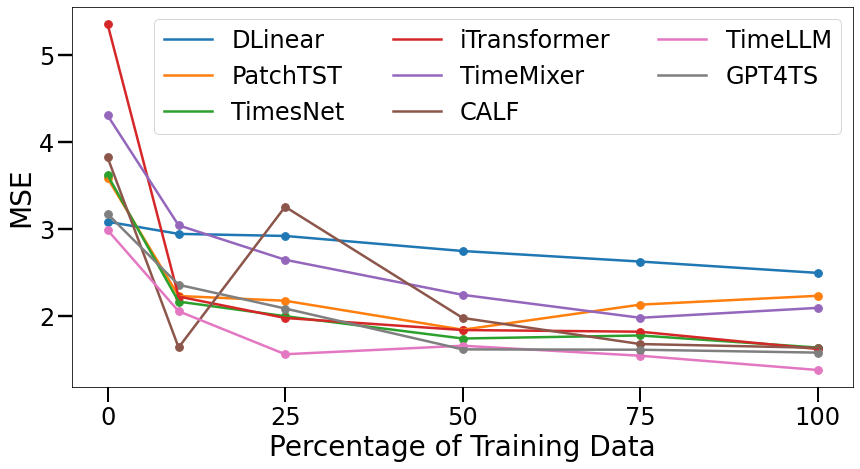

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for model in models:
    data = df[df['model'] == model]
    label  = model if model != 'OFA' else 'GPT4TS'
    
    data = data.groupby('percent')['mse'].mean().reset_index()
    
    ax.plot(data['percent'], data['mse'], label=label)
    ax.scatter(data['percent'], data['mse'], s=60)
    
ax.set_xlabel('Percentage of Training Data')
ax.set_ylabel('MSE')
ax.xaxis.set_major_locator(MultipleLocator(base=25))

plt.legend(ncols=3)
plt.savefig('results/Financial_Aid_State.jpg', dpi=200, bbox_inches="tight")
plt.show()

In [15]:
df = total_df[(total_df['dataset'] == 'Exchange_Rate_Report')]

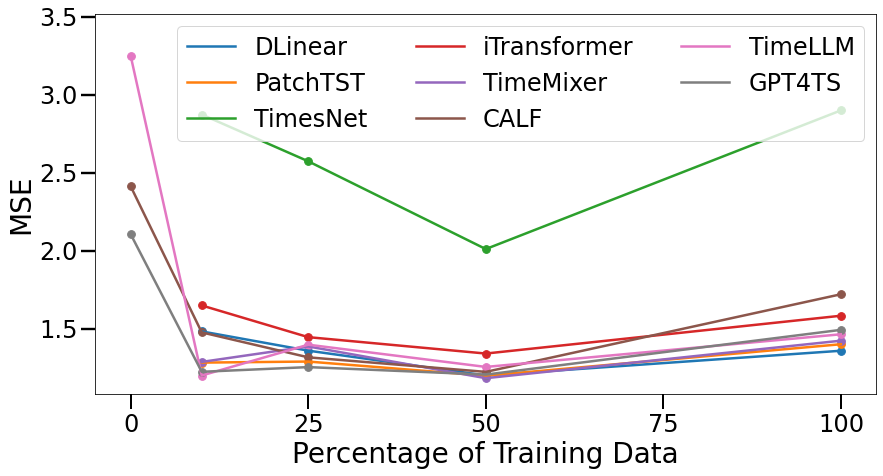

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

for model in models:
    data = df[df['model'] == model]
    label  = model if model != 'OFA' else 'GPT4TS'
    
    data = data.groupby('percent')['mse'].mean().reset_index()
    
    ax.plot(data['percent'], data['mse'], label=label)
    ax.scatter(data['percent'], data['mse'], s=60)
    
ax.set_xlabel('Percentage of Training Data')
ax.set_ylabel('MSE')

y_min, y_max = ax.get_ylim()
ax.set_ylim(y_min, y_max*1.05)
ax.xaxis.set_major_locator(MultipleLocator(base=25))

plt.legend(ncols=3, loc='upper right')
# plt.savefig('results/Financial_Aid_State_test.jpg', dpi=200, bbox_inches="tight")
plt.show()

## Financial Aid State

In [2]:
df = pd.read_csv('data/Financial_Aid_State.csv')
df = df.groupby('Date')['need_amt'].sum().reset_index()

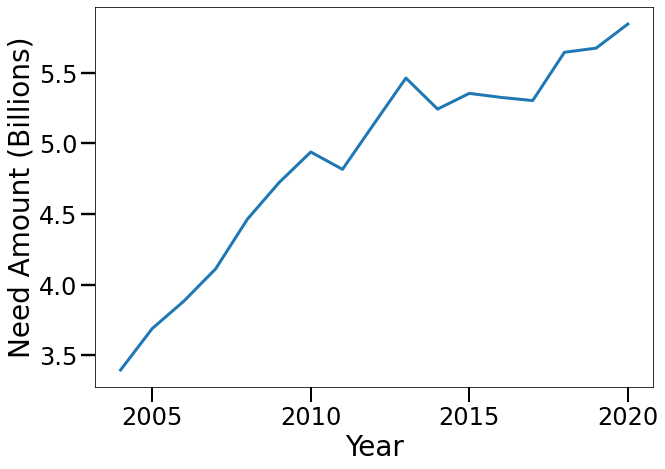

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
ax.plot(df['Date'], df['need_amt']/1e9, linewidth=3)
ax.set_xlabel('Year')
ax.set_ylabel('Need Amount (Billions)')
# plt.savefig('results/Financial_Aid_State.jpg', dpi=200, bbox_inches="tight") 
plt.show()

## Others

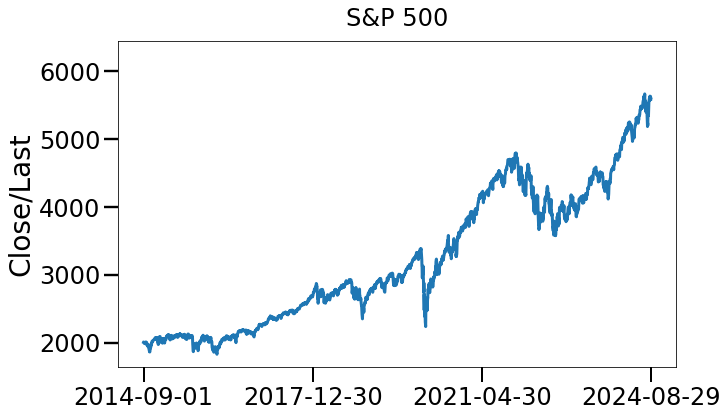

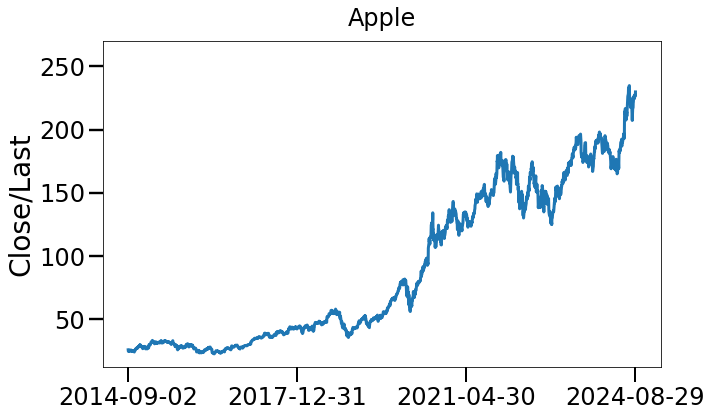

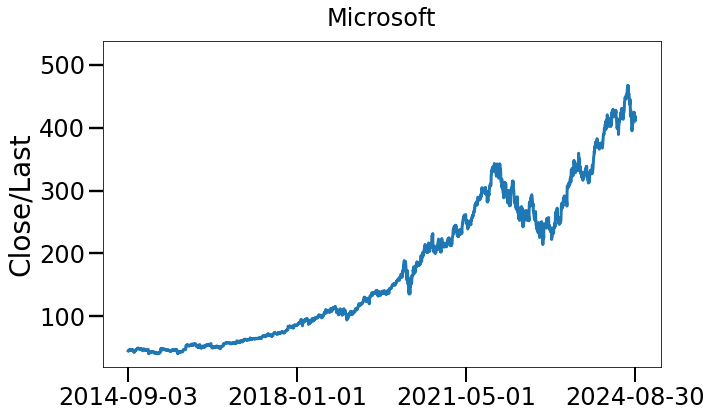

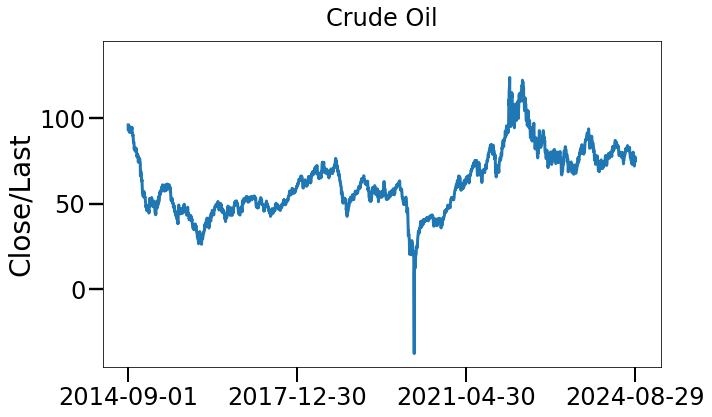

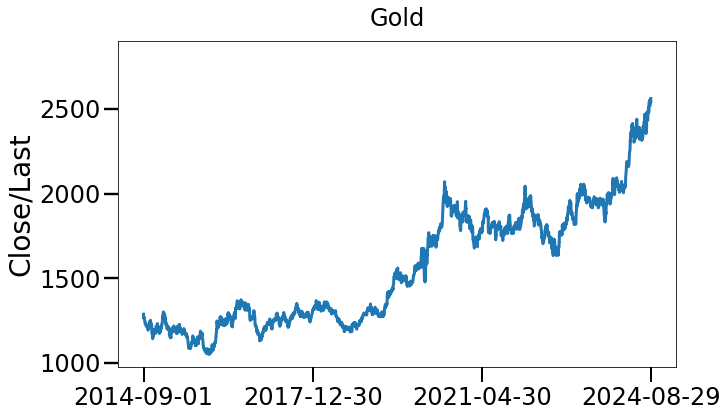

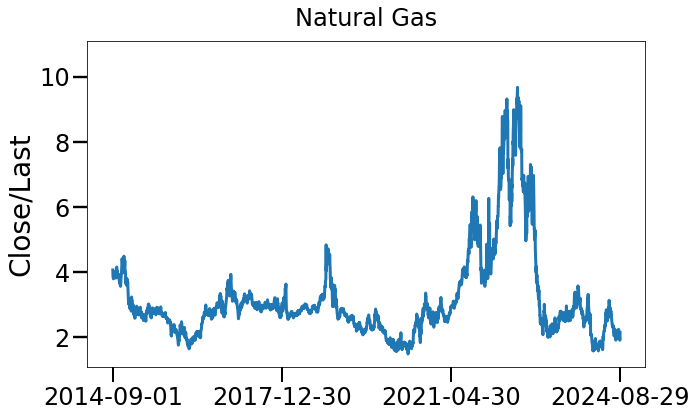

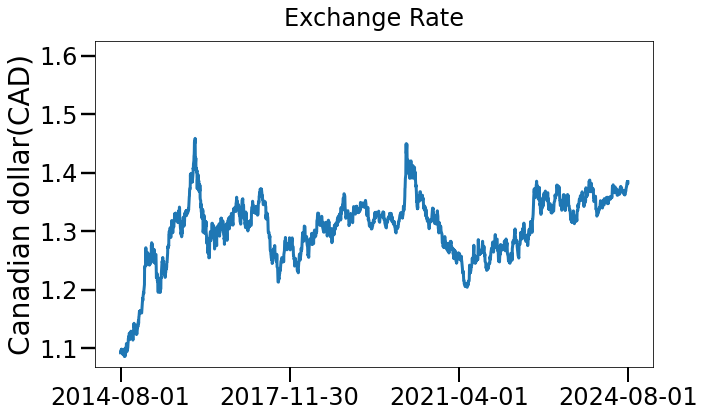

In [15]:
for dataset in datasets:
    if dataset == 'Financial_Aid_State': continue
    # print(dataset)
    df = pd.read_csv(f'data/{dataset}.csv')
    
    if dataset == 'Exchange_Rate_Report':
        target = 'Canadian dollar(CAD)'
    else:
        target = 'Close/Last'
        
    if df[target].dtype == 'object':
        df[target] = df[target].apply(
            lambda x: x.replace('$', '')
        ).astype('float')
    
    df['Date'] = pd.to_datetime(df['Date'])

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.plot(df['Date'], df[target], linewidth=3)
    # ax.set_xlabel('Date')
    ax.set_ylabel(target)
    # plt.savefig('results/Financial_Aid_State_raw.jpg', dpi=200, bbox_inches="tight") 

    # fix x axis
    x_first_tick = df['Date'].min()
    x_last_tick = df['Date'].max() 
    x_major_ticks = 4
    ax.set_xticks(
        [x_first_tick + (x_last_tick - x_first_tick) * i / (x_major_ticks - 1) for i in range(x_major_ticks)]
    )

    # fix y axis
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min, y_max*1.1)
    ax.set_title(datasets_map[dataset])

    plt.savefig(f'results/{dataset}.jpg', dpi=200, bbox_inches="tight")
    plt.show()